# Analysis and visualisation of loudness transformation functions

## Setup

In [ ]:
# -*- coding: utf-8 -*-
import sys
import os
# Build a path from the notebook's parent directory to the python modules
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# import statements
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
# set plot parameters
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 



Set the saveplots toggle to True if plot saving is desired:

In [3]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots '05 Impact\Articles\JASA_EL_2026_Q-SQM\Figures'")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


Define the phons array used in Table 5 of ISO 532-3:2023.

In [21]:
phons = np.array([4, 5, 7.5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65,
                  70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120])
data_MGS_phon2sone = np.array([0.004, 0.006, 0.014, 0.025, 0.066, 0.138,
                               0.252, 0.422, 0.664, 1.000, 1.460, 2.090, 2.950, 4.110,
                               5.710, 7.920, 11.00, 15.40, 21.70, 31.10, 44.70, 64.80,
                               94.30, 138.0, 205.0, 306.0])
level_Zwicker_TQ1kHz = 3  # level in dB of threshold in quiet for critical band corresponding with 1 kHz 1/3-octave band

Data obtained from Sottek Hearing Model loudness for phons (1 kHz sine).

In [22]:
data_Sottek_phon2sone = np.array([0.028483001, 0.034296099, 0.05170629,
                                  0.073919866, 0.137973828, 0.235170667, 0.366110736,
                                  0.533067637, 0.739628579, 0.999999649, 1.32574012,
                                  1.723452927, 2.203027636, 2.793495573, 3.536409689,
                                  4.50464193, 5.76494189, 7.418603572, 9.58630438,
                                  12.43914857, 16.24872669, 21.4505973, 28.68750645,
                                  38.83448119, 53.12617344, 73.42728902])

Calculated loudness using ISO 532-1 Zwicker model (Equation A.2 --- note that the exp(0.9845425) term is required to correct the core loudness transform to 1 sone at 40 phon)

In [23]:
calc_Zwicker_phon2sone = 0.0635*(10**(level_Zwicker_TQ1kHz/10))**0.25*((1 - 0.25 + 0.25*10**((phons - level_Zwicker_TQ1kHz)/10))**0.25 - 1)*np.exp(0.9845425)
calc_Zwicker_phon2sone[calc_Zwicker_phon2sone < 0] = 0  # set negative values to zero

Calculated loudness using alternative transform function obtained using non-linear optimisation.

In [24]:
def calc_ZwickerSottek_transform(excitation):
    q2 = 1.000021211
    q3 = 0.258048614
    q4 = 0.21013939
    q5 = -0.022253104
    q6 = 119.4977957
    q7 = -35.01262963

    q0 = q2*np.exp(-q3*excitation) + q4 + q5*np.tanh((excitation - q6)/q7)

    return q0

level_MGS_TQ1kHz_CBadj = 2.13
q0 = calc_ZwickerSottek_transform(phons)
q1 = 0.109999749
calc_ZwickerSottek_phon2sone = q1*(10**(level_MGS_TQ1kHz_CBadj/10))**q0*((1 - 0.25 + 0.25*10**((phons - level_MGS_TQ1kHz_CBadj)/10))**q0 - 1)*np.exp(0.9845425)
calc_ZwickerSottek_phon2sone[calc_ZwickerSottek_phon2sone < 0] = 0  # set negative values to zero

In [25]:
def calc_ZwickerMGS_transform(excitation):
    q2 = -0.25
    q3 = 0.1
    q4 = 0.293978767
    q5 = -0.021341126
    q6 = 119.9999655
    q7 = -43.0891087

    q0 = q2*np.exp(-q3*excitation) + q4 + q5*np.tanh((excitation - q6)/q7)

    return q0

q0 = calc_ZwickerMGS_transform(phons)
q1 = 0.050999899
calc_ZwickerMGS_phon2sone = q1*(10**(level_MGS_TQ1kHz_CBadj/10))**q0*((1 - 0.25 + 0.25*10**((phons - level_MGS_TQ1kHz_CBadj)/10))**q0 - 1)*np.exp(0.9845425)
calc_ZwickerMGS_phon2sone[calc_ZwickerMGS_phon2sone < 0] = 0  # set negative values to zero

Plot the resulting curves

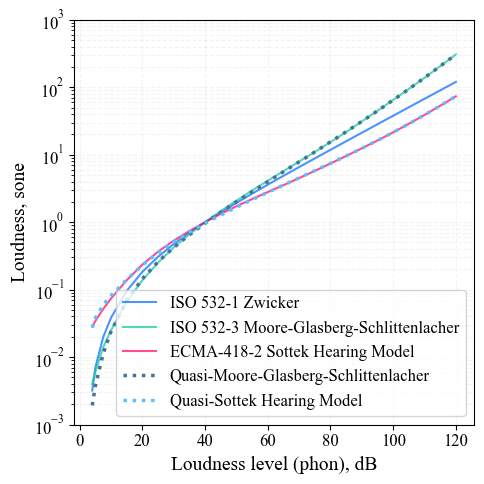

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.semilogy(phons, calc_Zwicker_phon2sone, color=mycolours[0], label='ISO 532-1 Zwicker', alpha=0.7)
ax.semilogy(phons, data_MGS_phon2sone, color=mycolours[1], label='ISO 532-3 Moore-Glasberg-Schlittenlacher', alpha=0.7)
ax.semilogy(phons, data_Sottek_phon2sone, color=mycolours[2], label='ECMA-418-2 Sottek Hearing Model', alpha=0.7)
ax.semilogy(phons, calc_ZwickerMGS_phon2sone, color=mycolours[3], label='Quasi-Moore-Glasberg-Schlittenlacher', markersize=0, alpha=1, linestyle=':', linewidth=2.5)
ax.semilogy(phons, calc_ZwickerSottek_phon2sone, color=mycolours[6], label='Quasi-Sottek Hearing Model', markersize=0, alpha=1, linestyle=':', linewidth=2.5)

ax.set(xlabel="Loudness level (phon), dB", ylabel="Loudness, sone",
       ylim=[1e-4, 1e3])
ax.grid(alpha=0.15, linestyle='--', which='both')
ax.legend(loc='lower right')

if saveplots:

    filename = "loudnessTransformComparison"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()